<a href="https://colab.research.google.com/github/emadazad/expected_delays/blob/main/Expected_Delays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

In this work, we aim to predict expected delays for departure flights. The process involves data preprocessing, exploratory data analysis (EDA), feature engineering, and implementing various models. As a result, we achieve better performance compared to the baseline model, with an overall average error (Mean Absolute Error) of approximately 10 minutes. While time and memory limitations prevented the implementation of certain improvement tactics, additional steps for model enhancement are shared throughout this work.


The work is divided into several sections:

**1. Preprocessing:** This section focuses on cleaning and processing the data, ensuring it is in a suitable format for analysis.

**2. Exploratory Data Analysis (EDA):** We examine important columns, explore the relationships between different variables, and analyze how the target variable correlates with other features.

**3. Modeling:** Two tree-based models (Random Forest and XGBoost) and a neural network are employed. Among them, XGBoost shows the highest predictive accuracy. However, it has less robust residuals compared to the other models. Moreover, it struggles with accurately classifying delay versus on-time flights.

**4. Conclusion and Next Steps:** In this section, we provide insights into improving model accuracy and suggest future steps to enhance the analysis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import warnings

# formatting
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Set the seed value
seed = 42

# Preprocessing

Cleaning and preprocessing the data, as well as applying business rules, are performed in this section. The specific steps and details are outlined below:


*   DELAY definition is applied to our datasets
*   Only subset of the 8 most common carriers are considered
*   Cancelled flights are removed from this work. Because expected delay is not defined for them and they can be studied in a separate work.
*   Outliers and missing values are addressed *(^)*
*   Columns are analyzed *(^)*

Each block within the code provides further details on how these processes are carried out.


*(^) EDA section will continue to work on these area*

In [ ]:
# read datasets into a dataframe and separate the test data
filename_pattern = '2*.csv'
file_paths = glob.glob(filename_pattern)
test_file_paths = ['2019_07.csv', '2019_08.csv']
dfs = []
test_dfs = []
print('loading files...')
for i, file_path in enumerate(file_paths):
  print('({}/{}) - {}'.format(i+1, len(file_paths), file_path))
  df = pd.read_csv(file_path, index_col=None)
  if file_path not in test_file_paths:
    dfs.append(df)
  else:
    test_dfs.append(df)

data = pd.concat(dfs)
test_data = pd.concat(test_dfs)
# save memory space
del dfs, test_dfs

loading files...
(1/14) - 2018_12.csv
(2/14) - 2018_10.csv
(3/14) - 2019_03.csv
(4/14) - 2018_07.csv
(5/14) - 2018_09.csv
(6/14) - 2019_04.csv
(7/14) - 2019_05.csv
(8/14) - 2019_02.csv
(9/14) - 2019_06.csv
(10/14) - 2018_11.csv
(11/14) - 2019_01.csv
(12/14) - 2018_08.csv
(13/14) - 2019_07.csv
(14/14) - 2019_08.csv


In [ ]:
data.head(3)

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 22
0,2018-12-01,9E,3295,JFK,ORF,1450,1446.0,-4.0,1627,1620.0,-7.0,0.0,NaN,97.0,94.0,59.0,290.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-12-01,9E,3296,MBS,DTW,600,557.0,-3.0,705,713.0,8.0,0.0,NaN,65.0,76.0,31.0,98.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-12-01,9E,3297,ATL,AEX,1901,1856.0,-5.0,1951,1941.0,-10.0,0.0,NaN,110.0,105.0,91.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# check types
pd.DataFrame(data.dtypes).transpose()

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 22
0,object,object,int64,object,object,int64,float64,float64,int64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [ ]:
# FL_DATE needs to be converted to data_time
data['FL_DATE'] = pd.to_datetime(data['FL_DATE'])
test_data['FL_DATE'] = pd.to_datetime(test_data['FL_DATE'])

# parsing the data time column
data['YEAR'] = data.FL_DATE.dt.year
data['MONTH'] = data.FL_DATE.dt.month
data['WEEKDAY'] = data.FL_DATE.dt.weekday
test_data['YEAR'] = test_data.FL_DATE.dt.year
test_data['MONTH'] = test_data.FL_DATE.dt.month
test_data['WEEKDAY'] = test_data.FL_DATE.dt.weekday

In [ ]:
# filter datasets to include only the top 8 most common carriers and
# exclude any cancelled flights
common_carriers = data.OP_UNIQUE_CARRIER.value_counts().nlargest(8).index
data = data[(data.OP_UNIQUE_CARRIER.isin(common_carriers)) &\
            (data.CANCELLED == 0)]
test_data = test_data[(test_data.OP_UNIQUE_CARRIER.isin(common_carriers)) &\
                      (test_data.CANCELLED == 0)]

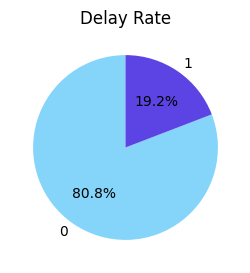

In [ ]:
# add definition of delay to data
data['DELAYED'] = np.where(data.DEP_DELAY >= 15, 1, 0)
test_data['DELAYED'] = np.where(test_data.DEP_DELAY >= 15, 1, 0)

# create a pie chart of delays
fig, ax = plt.subplots(figsize=(3, 3))
data.DELAYED.value_counts().plot.pie(autopct='%1.1f%%',
                                     startangle=90,
                                     ax=ax)
plt.title('Delay Rate')
plt.ylabel('')
plt.show()

Most of the columns are well populated, except for five columns related to the type of delay. For columns with approximately 2% missing values, we will simply drop those rows. Notably, this percentage will decrease to under 0.5% if we exclude cancelled flights.

In [ ]:
(data.isna().mean()*100.0).sort_values(ascending=False).reset_index()

,index,0
0,Unnamed: 22,100.000000
1,CANCELLATION_CODE,100.000000
2,LATE_AIRCRAFT_DELAY,80.334009
3,SECURITY_DELAY,80.334009
4,NAS_DELAY,80.334009
5,WEATHER_DELAY,80.334009
6,CARRIER_DELAY,80.334009
7,ARR_DELAY,0.273849
8,ACTUAL_ELAPSED_TIME,0.273849
9,AIR_TIME,0.273849


Weather delays account for a significant portion, approximately 36%, of all delays. Thus, having access to weather information could be advantageous for our analysis. However, it is important to note that this information is currently unavailable due to the absence of hourly data for the origin airports.

Furthermore, using weather data from nearby cities on a daily level may introduce the risk of data leakage. This is because severe weather conditions observed during a specific time period may not be representative of the entire day, and vice versa. Therefore, we will not use these two columns.

In [ ]:
data['ALL_WEATHER_DELAY'] = np.where(data.NAS_DELAY.fillna(0) + \
                                     data.WEATHER_DELAY.fillna(0) > 0,
                                     1,
                                     0)
(pd.crosstab(data['ALL_WEATHER_DELAY'],
             data['DELAYED'],
             normalize='columns')*100).round(1)

DELAYED,0,1
ALL_WEATHER_DELAY,,
0,94.6,63.9
1,5.4,36.1


Additionally, we exclude the other types of delays from consideration as they may contain information from the future, leading to data leakage.

In [ ]:
# drop less important columns
data.drop(['Unnamed: 22',
           'CANCELLATION_CODE',
           'CANCELLED',
           'WEATHER_DELAY',
           'NAS_DELAY',
           'SECURITY_DELAY',
           'LATE_AIRCRAFT_DELAY',
           'CARRIER_DELAY',
           'ALL_WEATHER_DELAY'],
          axis= 1,
          inplace=True)
# drop missing values
data.dropna(inplace=True)

In [ ]:
# check for missing values
assert data.isna().sum().sum() == 0

# Exploratory Data Analysis (EDA)

Here these important questions are answered:


1.   What is the distribution of departure delays?
2.   Are there specific carriers more prone to delays than others?
3.   Are there temporal patterns in departure delays?
4.   What is the relationship between departure delays and other variables?



In [ ]:
def plot_departure_delay_distribution(data):
  fig, axs = plt.subplots(1, 2, figsize=(12, 5))
  bins=100

  # plot distribution of departure delay for on-time flights (delay < 15 min)
  axs[0].hist(
      x=data[data.DELAYED == 0]['DEP_DELAY'],
      bins=bins
  )
  axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
  axs[0].set_title('Distribution of departure delay for on-time flights')
  axs[0].set_xlabel('Departure Delay')
  axs[0].set_ylabel('Count')

  # plot distribution of departure delay for delayed flights
  axs[1].hist(
      x=data[data.DELAYED == 1]['DEP_DELAY'],
      bins=bins
  )
  axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
  axs[1].set_title('Distribution of departure delay for delayed flights')
  axs[1].set_xlabel('Departure Delay')
  axs[1].set_ylabel('Count')

  # set layout and display the plot
  plt.tight_layout()
  plt.show()

## What is the distribution of departure delays?

As shown below, there are outliers present in both on-time and delayed flights. To address these outliers, we will employ the quantile-based approach instead of z-score method, which is known for its effectiveness in handling skewed or non-normal data. In this case, we will utilize the 0.01 and 0.99 quantiles to identify and treat the outliers accordingly.

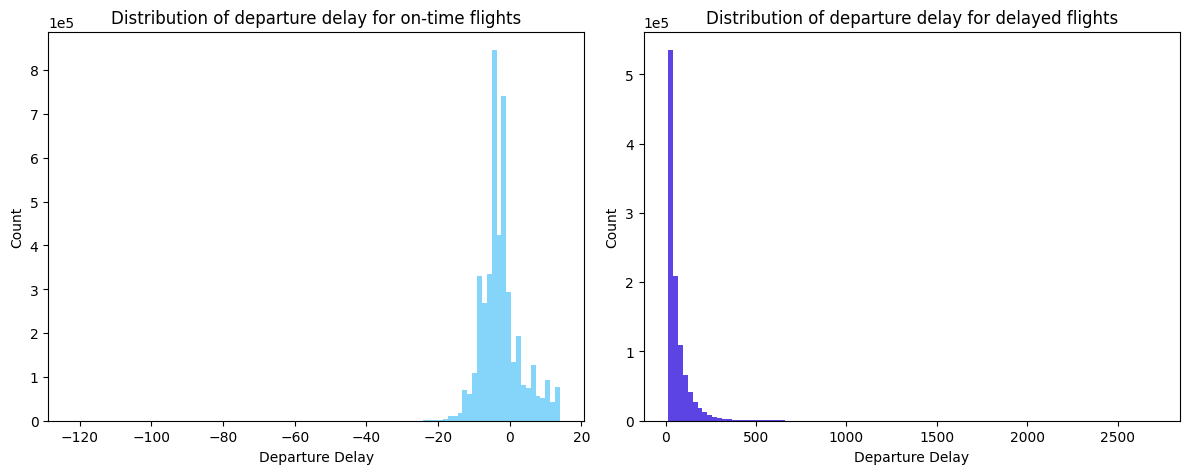

In [ ]:
plot_departure_delay_distribution(data)

In [ ]:
# Calculate the 0.01 and 0.99 quantiles for 'DEP_DELAY'
quantile_01 = data['DEP_DELAY'].quantile(0.01)
quantile_99 = data['DEP_DELAY'].quantile(0.99)

# calculate percentage of outliers
print('Outlier Percentage: {:.2f}%'\
      .format((1-((data['DEP_DELAY'] >= quantile_01) &\
                  (data['DEP_DELAY'] <= quantile_99)).mean())*100))

# filter data
data = data[(data['DEP_DELAY'] >= quantile_01) &\
            (data['DEP_DELAY'] <= quantile_99)]

print('Treated outliers for DEP_DELAY!')

Outlier Percentage: 1.87%
Treated outliers for DEP_DELAY!


After removing the outliers and plotting the charts again, we can observe that the distribution of delayed flights appears to be skewed, while the distribution of on-time flights exhibits a more normal shape.

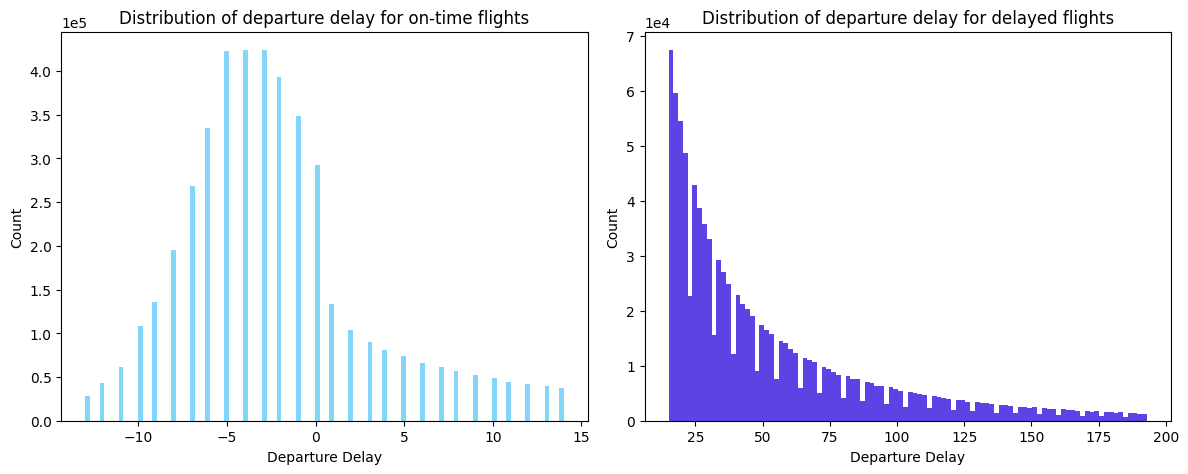

In [ ]:
plot_departure_delay_distribution(data)

In [ ]:
def plot_departure_delay_distribution_per_carrier(data):
  fig, axs = plt.subplots(2, 1, figsize=(12, 10))

  # plot mumber of flights per carrier
  flights_count_per_carrier_df = data.groupby(['OP_UNIQUE_CARRIER'])\
                                    .OP_CARRIER_FL_NUM.agg('count')\
                                    .reset_index()\
                                    .sort_values('OP_CARRIER_FL_NUM',
                                                  ascending=False)

  carriers = list(flights_count_per_carrier_df.OP_UNIQUE_CARRIER)
  sns.barplot(
      x='OP_UNIQUE_CARRIER',
      y='OP_CARRIER_FL_NUM',
      data=flights_count_per_carrier_df,
      ax=axs[0]
  )
  axs[0].set_xlabel('Carrier', fontsize=12)
  axs[0].set_ylabel('Number of Flights', fontsize=12)
  axs[0].set_title('Number of flights per carrier', fontsize=14)

  # plot distribution of departure delay per carrier
  g = sns.boxplot(
      x='OP_UNIQUE_CARRIER',
      y='DEP_DELAY',
      order=carriers,
      data=data,
      showfliers=False,
      ax=axs[1]
  )
  axs[1].set_ylabel('Departure Delay', fontsize=12)
  axs[1].set_xlabel('Carrier', fontsize=12)
  axs[1].set_title('Distribution of departure delay per carrier', fontsize=14)

  # add median annotations to the figure
  median_df = data.groupby(['OP_UNIQUE_CARRIER'])\
                  .DEP_DELAY\
                  .agg('median')\
                  .reset_index()\
                  .round(2)

  medians = list(median_df.set_index('OP_UNIQUE_CARRIER')\
                          .loc[carriers]\
                          .DEP_DELAY)

  for i in range(len(medians)):
      axs[1].annotate(medians[i],
                      xy=(i, medians[i]),
                      xytext=(0, 5),
                      textcoords='offset points',
                      ha='center',
                      va='center',
                      fontsize=12,
                      color='white',
                      weight='bold')

  # set layout and display the plot
  plt.tight_layout()
  plt.show()

## Are there specific carriers more prone to delays than others?

Interestingly, both the carriers with the highest and lowest number of flights display the widest range of delays and have a relatively high average delay. This suggests that carrier data could provide valuable insights for our modeling purposes.

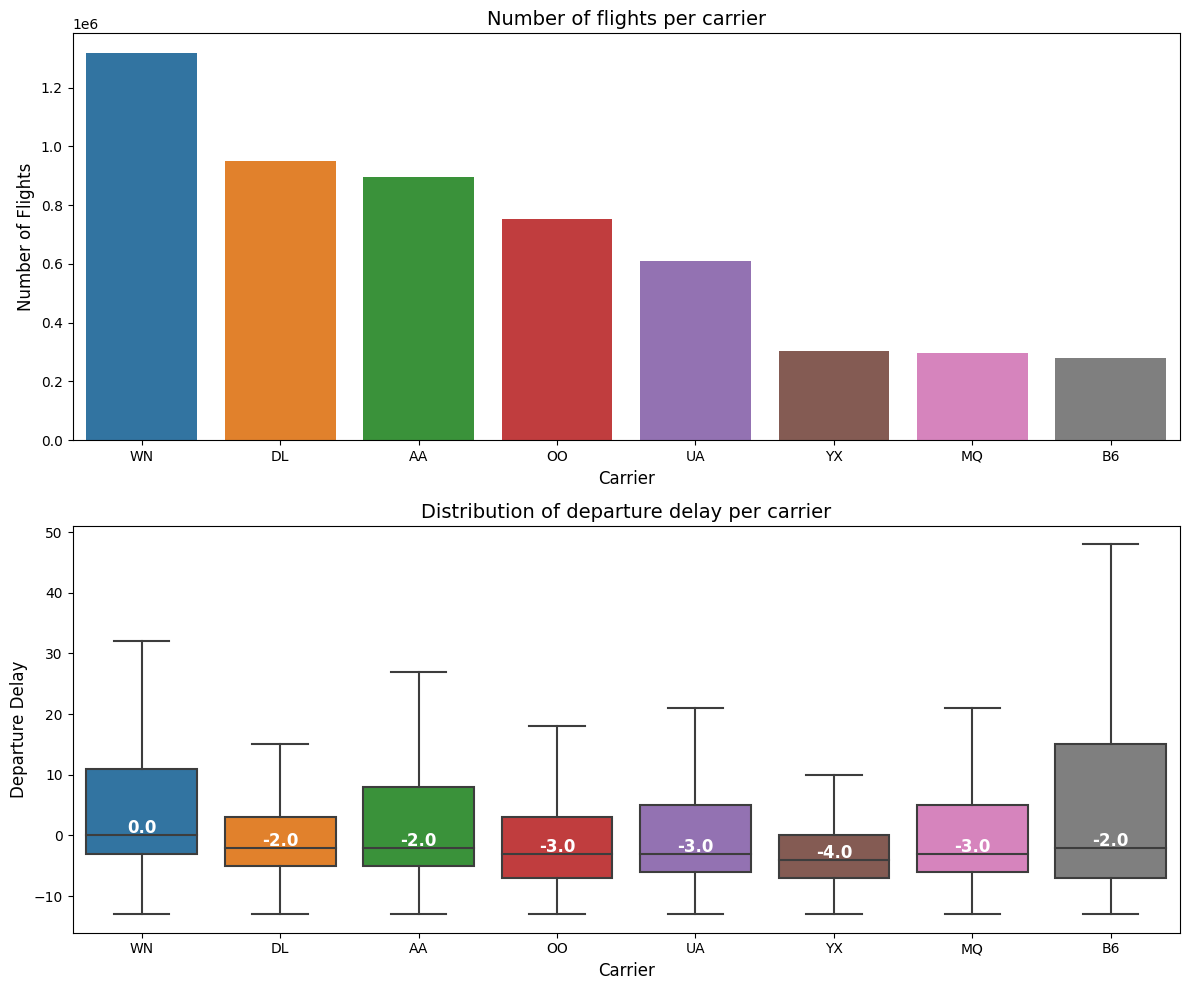

In [ ]:
plot_departure_delay_distribution_per_carrier(data)

In [ ]:
def plot_temporal_tend_of_departure_delay(data):
  fig, axs = plt.subplots(2, 1, figsize=(12, 10))

  flights_count_per_carrier_df = data.groupby(['OP_UNIQUE_CARRIER'])\
                                     .OP_CARRIER_FL_NUM.agg('count')\
                                     .reset_index()\
                                     .sort_values('OP_CARRIER_FL_NUM',
                                                  ascending=False)

  carriers = list(flights_count_per_carrier_df.OP_UNIQUE_CARRIER)

  # plot distribution of departure delay across weekdays
  sns.lineplot(
      x='WEEKDAY',
      y='DEP_DELAY',
      data=data,
      hue='OP_UNIQUE_CARRIER',
      hue_order=carriers,
      ci=None, # Remove error bar
      marker='o',
      legend=True,
      ax=axs[0]
  )
  axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
  axs[0].set_ylabel('Departure Delay', fontsize=12)
  axs[0].set_xlabel('Weekday', fontsize=12)
  axs[0].set_title('Distribution of departure delay across weekdays', size=14)
  axs[0].set_ylim(ymin=0)

  # plot distribution of departure delay across months
  sns.lineplot(
      x='MONTH',
      y='DEP_DELAY',
      data=data,
      hue='OP_UNIQUE_CARRIER',
      hue_order=carriers,
      ci=None, # Remove error bar
      marker='o',
      legend=True,
      ax=axs[1]
  )
  axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
  axs[1].set_ylabel('Departure Delay', fontsize=12)
  axs[1].set_xlabel('Month', fontsize=12)
  axs[1].set_title('Distribution of departure delay across months', size=14)
  axs[1].set_ylim(ymin=0)

  # set layout and display the plot
  plt.tight_layout()
  plt.show()

## Are there temporal patterns in departure delays?

Temporal patterns can be observed in departure delays. Notably, both weekday and monthly data exhibit distinct patterns. The figures clearly illustrate that Saturdays (5) tend to experience fewer delays compared to Fridays (4). Moreover, the months of September and October demonstrate fewer delays compared to the summer months.

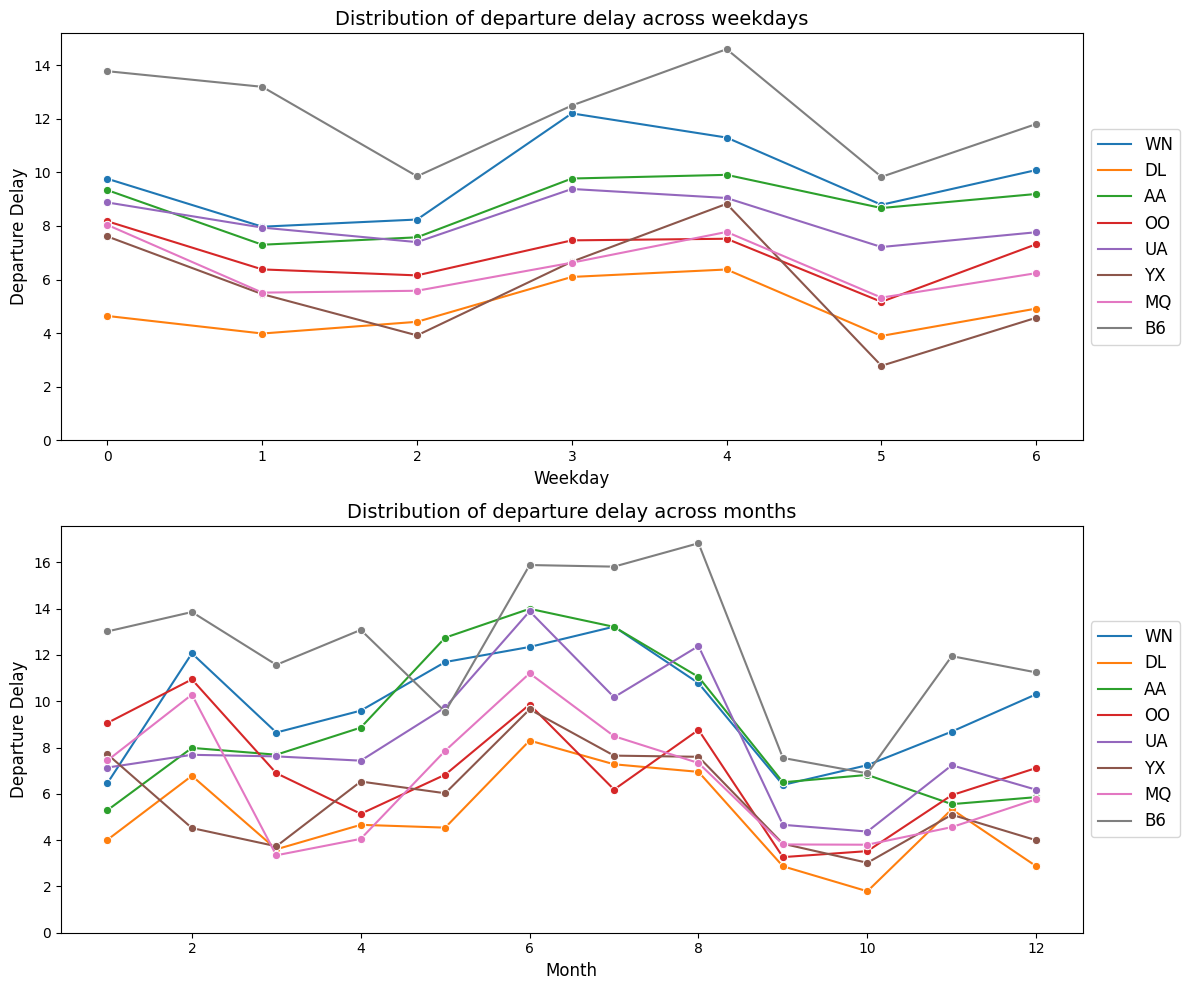

In [ ]:
plot_temporal_tend_of_departure_delay(data)

In [ ]:
def plot_correlation_matrix(data):
  # calculate the correlation matrix
  correlation_matrix = data.corr()

  fig, ax = plt.subplots(figsize=(16, 8))

  # create a heatmap of the correlation matrix
  sns.heatmap(
      data=correlation_matrix,
      cmap='coolwarm',
      vmin=-1,
      vmax=1,
      annot=True,
      fmt='.2f',
      linewidths=0.3,
      ax=ax
  )

  # customize the plot labels and title
  ax.set_xlabel('Features', fontsize=12)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  ax.set_ylabel('Features', fontsize=12)
  ax.set_title('Correlation Matrix Heatmap', fontsize=14)

  # set layout and display the plot
  plt.tight_layout()
  plt.show()

## What is the relationship between departure delays and other variables?

Based on the correlation matrix, we can observe the following:

*   Although Arrival data is correlated with our target variable, we cannot utilize it as it pertains to future information.
*   The Elapsed time, distance, and air time columns exhibit high correlation. To avoid redundancy, we will only use the distance column.
*   Due to the available data spanning the second half of 2018 and the first half of 2019, month and year variables have become highly correlated. As a result, we will exclude the year data from our analysis.


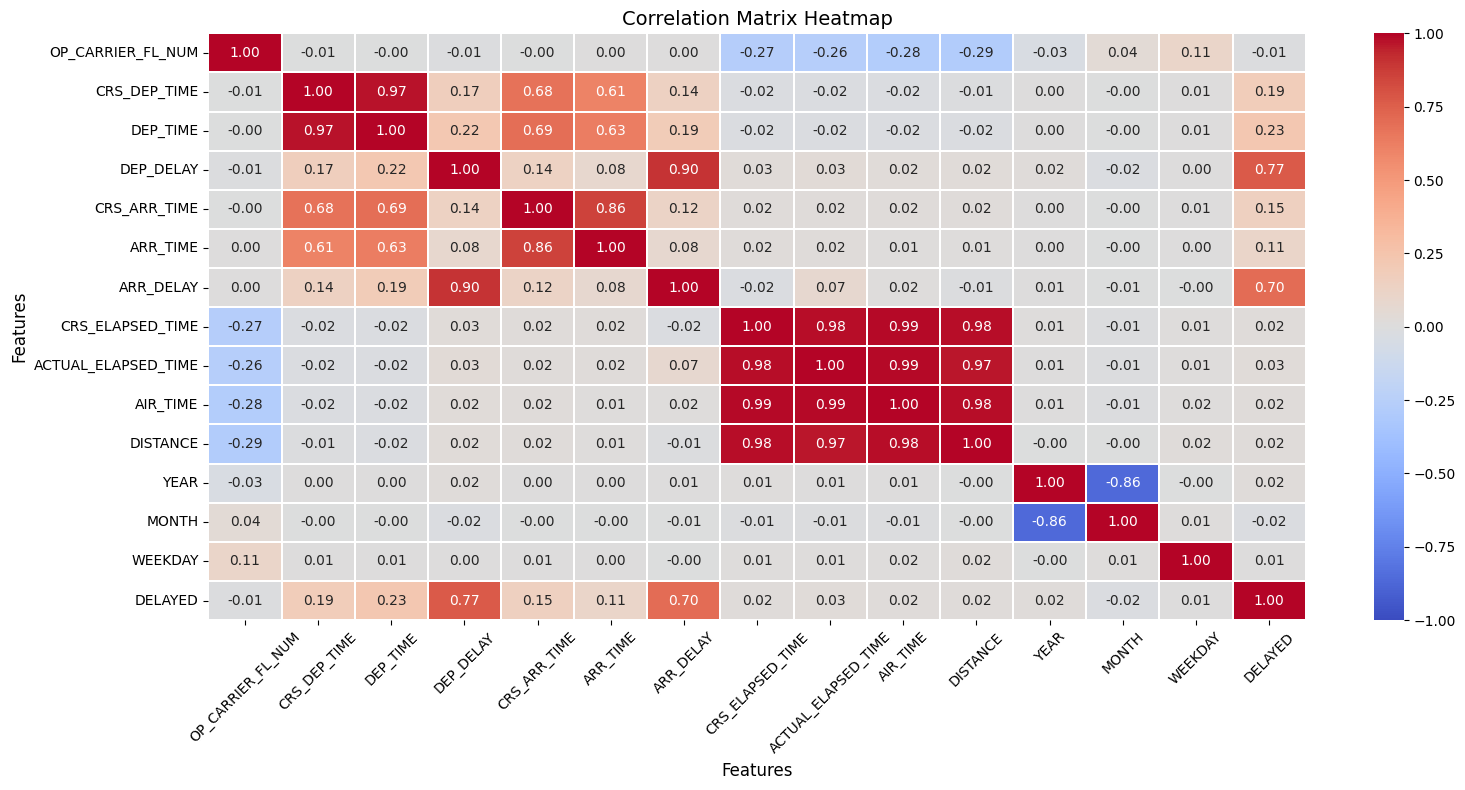

In [ ]:
plot_correlation_matrix(data)

When considering the categorical features, the 'DELAYED' column provides a valuable basis for studying them. Upon reviewing the histograms, it is evident that creating a pairwise grouping based on the 'ORIGIN-DEST' combination could be an excellent choice.

In [ ]:
def plot_delay_distribution_per_airport(data):
  fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharex=True)

  bins = 100

  # plot histogram for ORIGIN
  axs[0].hist(data.groupby('ORIGIN').DELAYED.mean(),
              bins=bins)
  axs[0].set_title('Distribution of delays per ORIGIN')
  axs[0].set_xlabel('Delay Rate')
  axs[0].set_ylabel('Count')

  # plot histogram for DEST
  axs[1].hist(data.groupby('DEST').DELAYED.mean(),
              bins=bins)
  axs[1].set_title('Distribution of delays per DEST')
  axs[1].set_xlabel('Delay Rate')
  axs[1].set_ylabel('Count')

  # plot histogram for ORIGIN-DEST
  axs[2].hist(data.groupby(['ORIGIN', 'DEST']).DELAYED.mean(),
              bins=bins)
  axs[2].set_title('Distribution of delays per ORIGIN-DEST')
  axs[2].set_xlabel('Delay Rate')
  axs[2].set_ylabel('Count')

  # set layout and display the plot
  plt.tight_layout()
  plt.show()

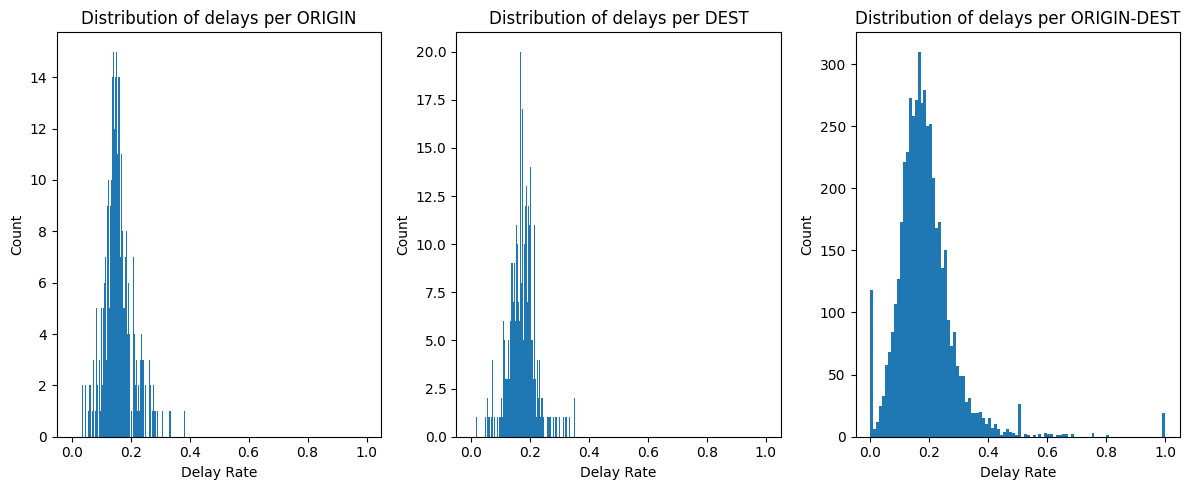

In [ ]:
plot_delay_distribution_per_airport(data)

# Feature Engineering

In [ ]:
# source: data.world
# https://data.world/sudipta/us-federal-holidays-2011-2020

# loading holiday data
holidays = pd.read_csv('us-federal-holidays-2011-2020.csv')
holidays['Date'] = pd.to_datetime(holidays.Date)
holidays['HOLIDAY'] = 1

In [ ]:
holidays[pd.to_datetime(holidays.Date).dt.year.isin([2018, 2019])].head()

,Date,Holiday,HOLIDAY
70,2018-01-01,New Year's Day,1
71,2018-01-15,"Birthday of Martin Luther King, Jr.",1
72,2018-02-19,Washington's Birthday,1
73,2018-05-28,Memorial Day,1
74,2018-07-04,Independence Day,1


In [ ]:
# add holiday information
data = data.merge(holidays,
                  how='left',
                  right_on='Date',
                  left_on='FL_DATE').fillna(0)
data.drop(['Date', 'Holiday'], axis=1, inplace=True)

test_data = test_data.merge(holidays,
                            how='left',
                            right_on='Date',
                            left_on='FL_DATE').fillna(0)
test_data.drop(['Date', 'Holiday'], axis=1, inplace=True)

In [ ]:
# create 12 buckets for scheduled departure time
data['CRS_DEP_TIME'] //= 200
test_data['CRS_DEP_TIME'] //= 200

In [ ]:
# create buckets for ORIGIN-DEST
bucket_ct = 10
origin_bucket = pd.cut(data.groupby(['ORIGIN', 'DEST']).DELAYED.mean(),
                       bucket_ct,
                       labels=range(bucket_ct))\
                       .reset_index()\
                       .rename(columns={'DELAYED': 'ORIGIN-DEST_BUCKET'})

data = data.merge(origin_bucket, on=['ORIGIN', 'DEST'])
test_data = test_data.merge(origin_bucket, on=['ORIGIN', 'DEST'])

In [ ]:
# create buckets for Distance
bucket_ct = 4
origin_bucket = pd.cut(data.groupby('DISTANCE').DELAYED.mean(),
                       bucket_ct,
                       labels=range(bucket_ct))\
                       .reset_index()\
                       .rename(columns={'DELAYED': 'DISTANCE_BUCKET'})

data = data.merge(origin_bucket, on='DISTANCE')
test_data = test_data.merge(origin_bucket, on='DISTANCE')

In [ ]:
# create numeric values for carriers
carrier_mapping = {
    carrier: i for i, carrier in enumerate(data['OP_UNIQUE_CARRIER'].unique())}

data['CARRIER_MAPPING'] = data['OP_UNIQUE_CARRIER']\
                              .map(carrier_mapping)

test_data['CARRIER_MAPPING'] = test_data['OP_UNIQUE_CARRIER']\
                                        .map(carrier_mapping)

In [ ]:
# create dummy variables
combined_df = pd.concat([data, test_data[data.columns]])

cat_columns = []

# get dummy values (one-hot encoding) for the combined dataset
combined_dummies = pd.get_dummies(combined_df,
                                  columns=cat_columns,
                                  drop_first=True)

# split the combined dataset back into train and test datasets
data_dummies = combined_dummies[:len(data)]
test_dummies = combined_dummies[len(data):]

# get new generated columns plus holiday data
col_names = list(data_dummies.columns[(data.columns.nunique()\
                                       - len(cat_columns)):])

# Modeling

In this section, we explore three different models: two tree-based models and one deep learning model. We evaluate these models based on their performance, particularly focusing on Mean Squared Error (RMSE) and Mean Absolute Error (MAE).

Please note that due to computational limitations and missing information, we had to allocate limited time for tuning the models. As a result, the models' performance is only slightly better than predicting the overall average delay, which serves as our baseline.

Upon evaluation, we found that the Neural Network model demonstrates more robustness in handling residuals compared to the tree-based models. Further tuning and optimization could potentially yield better results.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error

While a separate validation set is not explicitly defined, we employ 5-fold cross-validation in the tree-based models to assess their performance. Additionally, for the neural network, 20% of the training data is allocated as a validation set.

In [ ]:
# sample datasets to speed up modeling
sample_data = data.sample(500000, random_state=seed)
sample_test = test_data.sample(200000, random_state=seed)

## Baseline

Simply predicting the average delay in our dataset for all flights. The MAE and RMSE are as follow:

In [ ]:
def plot_erros(y_pred, residuals):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

  # plot the residual plot
  ax1.scatter(y_pred, residuals, s=10)
  ax1.axhline(y=0, color='r', linestyle='--')
  ax1.set_xlabel('Predicted values')
  ax1.set_ylabel('Residuals')
  ax1.set_title('Residual Plot')

  # plot the error distribution
  sns.histplot(residuals[residuals <= residuals.quantile(0.9)], kde=True, ax=ax2)
  ax2.set_xlabel('Residuals')
  ax2.set_ylabel('Frequency')
  ax2.set_title('Error Distribution')

  # set layout and display the plot
  fig.tight_layout()
  plt.show()

Mean Absolute Error: 21.78790036312
Root Mean Squared Error: 52.73030439345402
__________


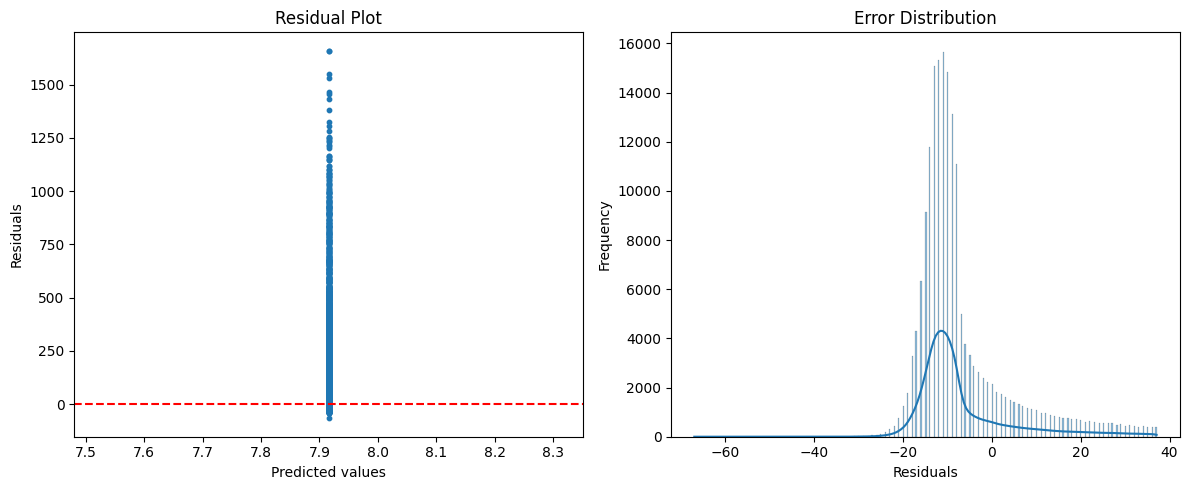

In [ ]:
# define the base model, train data average departure delay
y_pred_base = [sample_data.DEP_DELAY.mean()]*len(sample_test.DEP_DELAY)
residuals_base = sample_test.DEP_DELAY - y_pred_base

# print the evaluation metrics
print('Mean Absolute Error:',
      mean_absolute_error(sample_test.DEP_DELAY, y_pred_base))
print('Root Mean Squared Error:',
      mean_squared_error(sample_test.DEP_DELAY, y_pred_base)**0.5)

print('_'*10)
plot_erros(y_pred_base, residuals_base)

## Random Forest

In the case of Random Forest models, data normalization is not necessary as they are not sensitive to the scale of the input features. However, it is important to note that having a highly volatile variable can potentially affect the model's performance. To mitigate this issue, we have employed limited buckets or categories to prevent the volatile variable from negatively impacting the model.

Additionally, Random Forest models can be useful for feature importance analysis and feature reduction. Although, in this specific case, the dataset does not contain an extensive number of features.

In [ ]:
def train_random_forest(X_train, y_train, param_grid):
  # create the Random Forest Regressor model
  rf_model = RandomForestRegressor(random_state=seed)

  # perform GridSearchCV for hyperparameter tuning
  grid_search = GridSearchCV(estimator=rf_model,
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             cv=5)

  grid_search.fit(X_train, y_train)

  # get the best hyperparameters and model
  best_params = grid_search.best_params_
  print('best_params:', best_params)
  best_model = grid_search.best_estimator_

  # fit the model with the best hyperparameters on the training data
  best_model.fit(X_train, y_train)

  return best_model


def evaluate_RF_model(X_test, y_test, model):
  # use the model to make predictions on the test data
  y_pred = model.predict(X_test)

  residuals = y_test - y_pred

  # evaluate the model's performance
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)

  # print the evaluation metrics
  print('Mean Absolute Error:', mae)
  print('Root Mean Squared Error:', rmse)

  return y_pred, residuals

best_params: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 300}
Mean Absolute Error: 21.870158652638917
Root Mean Squared Error: 51.87900234911358
__________


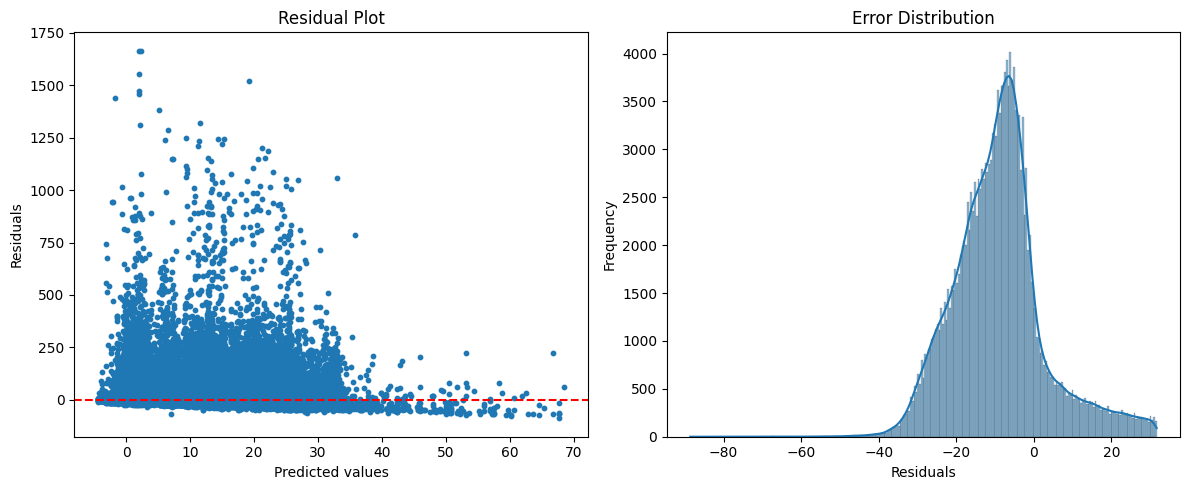

CPU times: user 17min 48s, sys: 1.79 s, total: 17min 49s
Wall time: 17min 45s


In [ ]:
%%time
# !!! takes +18 min to run !!!

# set hyperparameter serach for tuning
param_grid = {
        'n_estimators': [300],
        'max_depth': [10],
        'min_samples_leaf': [5], # prevent overfitting
        # 'max_features': ['auto', 'sqrt'] # ignored to expedite training
        }

features = ['CARRIER_MAPPING',
            'ORIGIN-DEST_BUCKET',
            'CRS_DEP_TIME',
            'DISTANCE_BUCKET',
            'MONTH',
            'WEEKDAY',
            'HOLIDAY'
            ]

# prepare your train and test data
X_train, y_train = sample_data[features], sample_data['DEP_DELAY']
X_test, y_test = sample_test[features], sample_test['DEP_DELAY']

# train the Random Forest model
rf_model = train_random_forest(X_train, y_train, param_grid)

# evaluate the model's performance on the test data
y_pred, residuals = evaluate_RF_model(X_test, y_test, rf_model)
print('_'*10)
plot_erros(y_pred, residuals)

In [ ]:
# error based on definition of delay
threshold = 15 # minutes

y_pred_binary = (y_pred >= threshold).astype(int)

# actual delays
y_test_binary = (y_test >= threshold).astype(int)

# check the f1_score for both delay and on-time flights
print(classification_report(y_test_binary, y_pred_binary))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80    158945
           1       0.33      0.46      0.39     41055

    accuracy                           0.70    200000
   macro avg       0.59      0.61      0.59    200000
weighted avg       0.74      0.70      0.72    200000



Mean Absolute Error: 11.630538916523847
Root Mean Squared Error: 14.199289337732328
__________


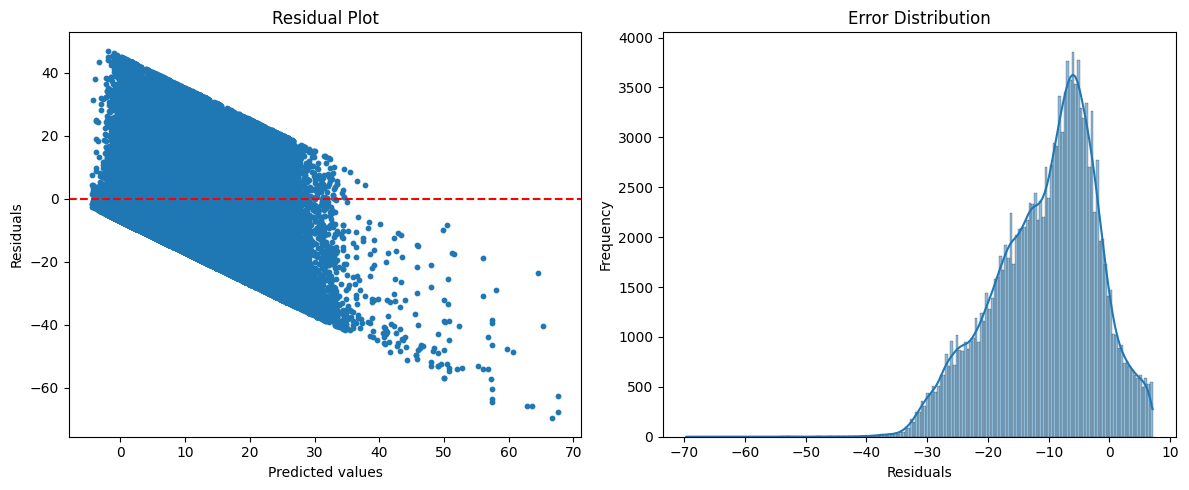

In [ ]:
# check the error after removing outliers from the test set
new_sample_test = sample_test[(sample_test['DEP_DELAY'] >= \
                               sample_test['DEP_DELAY'].quantile(0.1)) &\
                              (sample_test['DEP_DELAY'] <= \
                               sample_test['DEP_DELAY'].quantile(0.9))]

X_test, y_test = new_sample_test[features], new_sample_test['DEP_DELAY']

y_pred, residuals = evaluate_RF_model(X_test, y_test, rf_model)
print('_'*10)
plot_erros(y_pred, residuals)

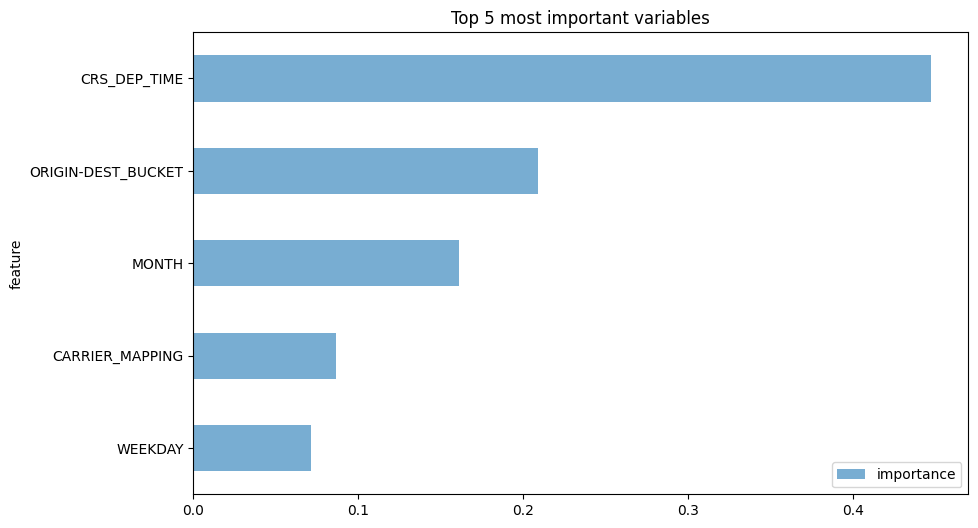

In [ ]:
feature_importances_data = []
features = X_train.columns
for feature_name, feature_importance in zip(features,
                                            rf_model.feature_importances_):
    feature_importances_data.append({
        'feature': feature_name,
        'importance': feature_importance
    })

# plot the results
pd.DataFrame(feature_importances_data)\
    .set_index('feature')\
    .sort_values(by='importance')[-5::]\
    .plot(title='Top 5 most important variables',
          kind='barh',
          figsize=(10, 6),
          alpha=0.6,
          lw=1)
plt.show()

## XGBoost

In contrast to Random Forest models, XGBoost models and Neural Networks typically benefit from data normalization. Therefore, we will utilize standard scaling to normalize the data for these models. Additionally, we have accounted for the class imbalance in the dataset. After all, achieving an **average error of 10 minutes** for both MAE and RMSE can be considered a significant success.

On the other hand, it is important to note that XGBoost, being an ensemble model, introduces some volatility in the residuals. Also, this model faces challenges in accurately classifying delay versus on-time flights. **These factors should be taken into consideration when evaluating the model's performance and making decisions based on its predictions.**

In [ ]:
def train_xgboost(X_train, y_train, param_grid, class_ratio=None):
  # create the XGBoost Regressor model
  xgb_model = xgb.XGBRegressor(random_state=seed,
                               scale_pos_weight=class_ratio)

  # Perform GridSearchCV for hyperparameter tuning
  grid_search = GridSearchCV(estimator=xgb_model,
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             cv=5)

  grid_search.fit(X_train, y_train)

  # get the best hyperparameters and model
  best_params = grid_search.best_params_
  best_model = grid_search.best_estimator_

  # fit the model with the best hyperparameters on the training data
  best_model.fit(X_train, y_train)

  return best_model

def evaluate_XGB_model(X_test, y_test, model=None, y_scaler=None):
  # use the model to make predictions on the test data
  # if not model:
  #   y_pred = [y_scaler.inverse_transform(y_test).mean()]*len(y_test)
  # else:
  y_pred = model.predict(X_test)
  y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))


  residuals = y_test - y_pred

  # evaluate the model's performance
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)

  # print the evaluation metrics
  print('Mean Absolute Error:', mae)
  print('Root Mean Squared Error:', rmse)

  return y_pred, residuals

Mean Absolute Error: 10.106738861769283
Root Mean Squared Error: 11.750962531128442
__________


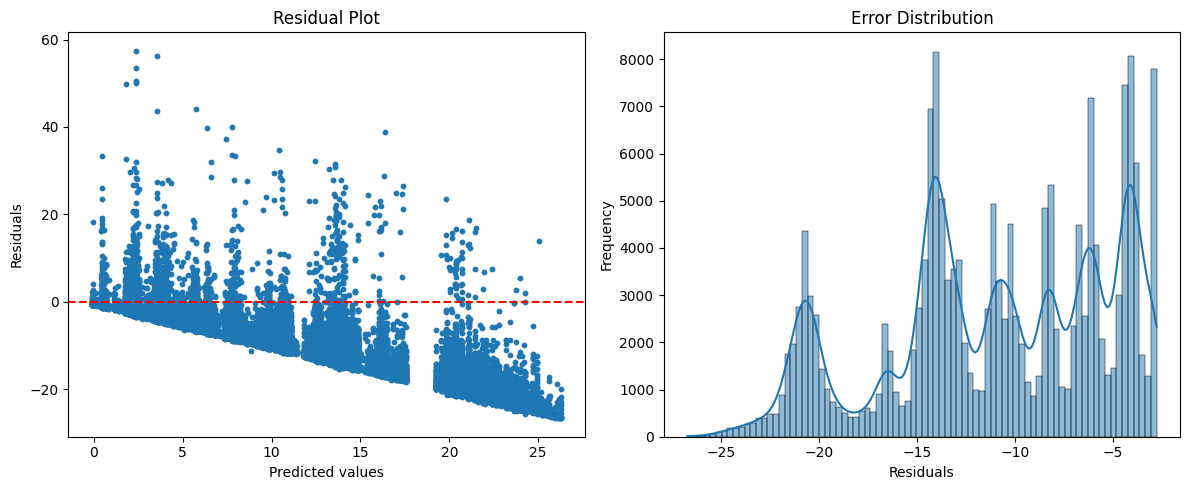

CPU times: user 36min 55s, sys: 2.58 s, total: 36min 58s
Wall time: 10min 8s


In [ ]:
%%time
# set hyperparameter serach for tuning
param_grid = {
        'n_estimators': [300],
        'learning_rate': [0.01],
        'max_depth': [3],
        'min_child_weight': [1, 3],
        'subsample': [0.6, 1.0]
    }

# normalize the columns
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_scaler.fit(sample_data[features])
y_scaler.fit(sample_data['DEP_DELAY'].values.reshape(-1, 1))

# prepare your train and test data
X_train = x_scaler.transform(sample_data[features])
X_train = pd.DataFrame(X_train, columns=features)

X_test = x_scaler.transform(sample_test[features])
X_test = pd.DataFrame(X_test, columns=features)

y_train = y_scaler.transform(sample_data['DEP_DELAY'].values.reshape(-1, 1))
y_test = y_scaler.transform(sample_test['DEP_DELAY'].values.reshape(-1, 1))

# train the XGBoost model
xgb_model = train_xgboost(X_train,
                          y_train,
                          param_grid,
                          sample_data['DELAYED'].mean())

# evaluate the model's performance on the test data
y_pred, residuals = evaluate_XGB_model(X_test, y_test, xgb_model, y_scaler)
print('_'*10)
plot_erros(y_pred, pd.Series(residuals.flatten()))

In [ ]:
# error based on definition of delay
threshold = 15 # minutes

y_pred_binary = (y_pred >= threshold).astype(int)

# actual delays
y_test_binary = (y_test >= threshold).astype(int)

# check the f1_score for both delay and on-time flights
print(classification_report(y_test_binary, y_pred_binary))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90    199572
           1       0.00      0.29      0.01       428

    accuracy                           0.81    200000
   macro avg       0.50      0.55      0.45    200000
weighted avg       1.00      0.81      0.90    200000



## Deep Learning

A vanilla neural network is trained here. With the abundance of data, there is a strong potential for the model to yield exceptional results. By dedicating more time to feature engineering and fine-tuning the model, we can optimize its performance and achieve better outcomes.

In [ ]:
# build a vanila neural net with 3 layers
class NeuralNetModel:
    def __init__(self):
        self.model = None
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()

    def preprocess_data(self, X_train, y_train, X_test, y_test):
        self.x_scaler.fit(X_train)
        X_train_scaled = self.x_scaler.transform(X_train)
        X_test_scaled = self.x_scaler.transform(X_test)
        self.y_scaler.fit(y_train.values.reshape(-1, 1))
        y_train_scaled = self.y_scaler.transform(y_train.values.reshape(-1, 1))
        y_test_scaled = self.y_scaler.transform(y_test.values.reshape(-1, 1))
        return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled

    def build_model(self):
        self.model = Sequential()
        self.model.add(Dense(8,
                             activation='relu',
                             input_shape=X_train_scaled.shape[1:]))
        self.model.add(Dense(4,
                             activation='relu'))
        self.model.add(Dense(1))
        adam_optimizer = keras.optimizers.Adam(learning_rate=0.001)
        self.model.compile(loss='mean_squared_error',
                           optimizer=adam_optimizer)

    def train_model(self, X_train, y_train, epochs=5, batch_size=16,
                    validation_split=0.2, verbose=1):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                       validation_split=validation_split, verbose=verbose)

    def predict(self, X):
        return self.model.predict(X)

    def inverse_transform(self, y):
        return self.y_scaler.inverse_transform(y)

    def calculate_error(self, y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse, mae

In [ ]:
# create an instance of the NeuralNetModel
model = NeuralNetModel()

# Preprocess the data
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = \
                  model.preprocess_data(sample_data[features],
                                        sample_data['DEP_DELAY'],
                                        sample_test[features],
                                        sample_test['DEP_DELAY'])


# build the model
model.build_model()

# train the model
model.train_model(X_train_scaled, y_train_scaled)

# make predictions
y_pred_scaled = model.predict(X_test_scaled)

# inverse transform the predicted values
y_pred_actual = model.inverse_transform(y_pred_scaled)

# inverse transform the true values
y_test_actual = model.inverse_transform(y_test_scaled)

Epoch 1/5
25000/25000 [==============================] - 45s 2ms/step - loss: 0.9595 - val_loss: 0.9550
Epoch 2/5
25000/25000 [==============================] - 46s 2ms/step - loss: 0.9530 - val_loss: 0.9532
Epoch 3/5
25000/25000 [==============================] - 43s 2ms/step - loss: 0.9517 - val_loss: 0.9517
Epoch 4/5
25000/25000 [==============================] - 41s 2ms/step - loss: 0.9512 - val_loss: 0.9520
Epoch 5/5
6250/6250 [==============================] - 8s 1ms/step


In [ ]:
# calculate and print the RMSE
rmse, mae = model.calculate_error(y_test_actual, y_pred_actual)
print('MAE:', mae)
print('RMSE:', rmse)

print('_'*10)

# calculate and print the RMSE with baseline
base = [sample_data.DEP_DELAY.mean()] * len(y_test_actual)
rmse_base, mae_base = model.calculate_error(y_test_actual, base)
print('Baseline MAE:', mae_base)
print('Baseline RMSE:', rmse_base)

MAE: 21.10470448714036
RMSE: 52.02497345095635
__________
Baseline MAE: 21.78790036312
Baseline RMSE: 52.73030439345402


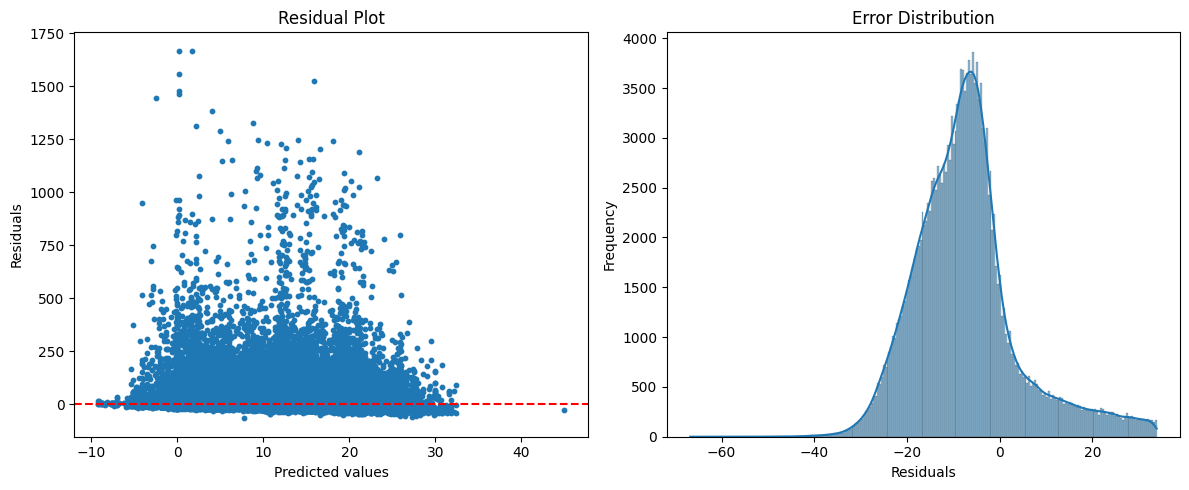

In [ ]:
plot_erros(y_pred_actual,
           pd.Series((y_test_actual.flatten() - y_pred_actual.flatten())))

In [ ]:
# error based on definition of delay
threshold = 15 # minutes

y_pred_binary = (y_pred_actual >= threshold).astype(int)

# actual delays
y_test_binary = (y_test_actual >= threshold).astype(int)

# check the f1_score for both delay and on-time flights
print(classification_report(y_test_binary, y_pred_binary))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84    158945
           1       0.35      0.33      0.34     41055

    accuracy                           0.74    200000
   macro avg       0.59      0.59      0.59    200000
weighted avg       0.73      0.74      0.73    200000



# Conclusion and Nest Steps

**Conclusion:**

* Both the Random Forest (RF) and Neural Network (NN) models demonstrated slightly better accuracy compared to the base model, while XGBoost did not yield satisfactory results.

* The Random Forest model identified the scheduled time of departure as the most significant feature for predicting delays.

* Although the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) show slight improvement, both the RF and NN models performed adequately in classifying flights as on-time or delayed.


**Next Steps for Model Improvement:**

* Incorporate information about the previous flight that lands just before the specific flight. Although this can be beneficial, the availability of such data is limited for the majority of the target airplanes. That is, only one or two flights are scheduled for a particular flight number in a day.

* Utilize weather information effectively, as mentioned in the EDA section, to enhance the models.

* Consider historical delays, such as the expected delay for a specific flight in the previous week or during the last few days. This type of feature was not addressed in this study.

* Apply the weight of evidence and information value techniques for better binning and bucket creation, rather than fixed bin sizes.
